# Info

In this notebook we use a predefined test system and show how we can extract thermodynamic informations from OpenMM.

The test system of choice is a diatom argon.

## Targets
* learn how to use `openmmtools.testsystems.Diatom`
* learn how to extract different properties during a simulation run
* learn how to calculate the `temperature` and the `kinetic energy` by your self

## OpenMMTools : Test systems

a full overview about all test systems is given in : 
* https://openmmtools.readthedocs.io/en/0.17.0/testsystems.html

In [1]:
import simtk.openmm.app as app
import simtk.openmm as mm
from simtk.unit import *

import openmmtools

import matplotlib.pyplot as plt
import numpy as np

from copy import deepcopy

## Diatom
Create a free diatomic molecule with a single harmonic bond between the two atoms.


> The natural period of a harmonic oscillator is T = sqrt(m/K), so you will want to use an integration timestep smaller than ~ T/10.

Define parameters for a di-argon system.

In [2]:
K = 290.1 * kilocalorie / (angstrom**2 * mole)
r0 = 1.55 * angstrom

m1 = 39.948 * dalton
m2 = 39.948 * dalton

Estimate the required time step.

In [3]:
mu =  (m1*m2)/(m1+m2) # reduced mass
T = sqrt(mu / K)
print("T    : {}".format(T.in_units_of(femtosecond)))
print("T/10 : {}".format(T.in_units_of(femtosecond)/10))

T    : 12.828114286734632 fs
T/10 : 1.2828114286734633 fs


Create the diatom system

In [4]:
diatom = openmmtools.testsystems.Diatom(K=K, r0=r0, m1=m1, m2=m2)

Create a simulation object.

In [5]:
integrator = mm.VerletIntegrator(1 * femtosecond)

simulation = app.Simulation(topology=diatom.topology,
                            system=diatom.system,
                            integrator=integrator)
simulation.context.setPositions(diatom.positions)
simulation.context.setVelocitiesToTemperature(300*kelvin)

Do a simulation of system by repeatedly simulating the system for a short period of time.

After each period extract the desired values from the trajectory and store them into our list.

In [6]:
storage_harmonic_bond = {
    'positions'        : Quantity([], unit=angstrom),
    'velocities'       : Quantity([], unit=angstrom/femtosecond),
    'forces'           : Quantity([], unit=kilocalorie/(angstrom*mole)),
    'potential_energy' : Quantity([], unit=kilocalorie_per_mole),
    'kinetic_energy'   : Quantity([], unit=kilocalorie_per_mole),
}

# define a state
state = simulation.context.getState(getPositions=True, 
                                    getForces=True,
                                    getVelocities=True,
                                    getEnergy=True)

# add the first frame
storage_harmonic_bond['positions'].append(deepcopy( state.getPositions() ) )
storage_harmonic_bond['velocities'].append(deepcopy( state.getVelocities() ) )
storage_harmonic_bond['forces'].append(deepcopy( state.getForces() ))
storage_harmonic_bond['potential_energy'].append(deepcopy( state.getPotentialEnergy() ))
storage_harmonic_bond['kinetic_energy'].append(deepcopy( state.getKineticEnergy() ))

# repeatedly simulate the system for a short period
# extract the properties from the state
for i in range(1000):
    simulation.step(100)
    
    # define a state
    state = simulation.context.getState(getPositions=True, 
                                        getForces=True,
                                        getVelocities=True,
                                        getEnergy=True)
    
    # update storage
    storage_harmonic_bond['positions'].append(deepcopy( state.getPositions() ) )
    storage_harmonic_bond['velocities'].append(deepcopy( state.getVelocities() ) )
    storage_harmonic_bond['forces'].append(deepcopy( state.getForces() ))
    storage_harmonic_bond['potential_energy'].append(deepcopy( state.getPotentialEnergy() ))
    storage_harmonic_bond['kinetic_energy'].append(deepcopy( state.getKineticEnergy() ))

## Analysis

Let's analyze what we did.

## Potential energy as function of distance

As first we want to plot the potential energy as function of distance between the atoms.

Therefore, we first need to calculate the distance between the atoms as done in `get_bond_distance`.

In [7]:
def get_bond_distance(positions):
    # get the bond distance
    dx, dy, dz = positions[1] - positions[0]
    distance = sqrt(dx**2 + dy**2 + dz**2)
    return distance

list_r0 = Quantity([ get_bond_distance(pos) for pos in storage_harmonic_bond['positions'] ])

Text(0.5, 0, 'distance [$\\AA$]')

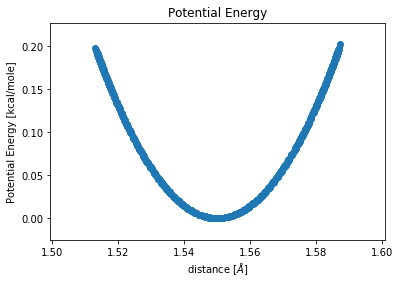

In [8]:
plt.title("Potential Energy")
plt.scatter(list_r0.value_in_unit(angstrom),
            storage_harmonic_bond['potential_energy'].value_in_unit(kilocalorie_per_mole))

plt.ylabel('Potential Energy [kcal/mole]')
plt.xlabel(r'distance [$\AA$]')

## Calculate Temperature

If we want to plot the temperature of the system, we have to calculate it as done in `calculate_temperature(kineticEnergy)`.

As we need the degree of freedom for this calculation we can automatically calculate them with `get_dof(system)`.

In [9]:
def get_dof(system):
    "get the degree of freedom"
    dof = 0
    for i in range(system.getNumParticles()):
        if system.getParticleMass(i) > 0*dalton:
            dof += 3
    dof -= system.getNumConstraints()
    if any(type(system.getForce(i)) == mm.CMMotionRemover for i in range(system.getNumForces())):
        dof -= 3
    return dof

def calculate_temperature(kineticEnergy):
    "caclulates the temperature from the kinetic energy"
    temperature = (2*kineticEnergy/(dof*MOLAR_GAS_CONSTANT_R)).in_units_of(kelvin)
    return temperature

In [10]:
dof = get_dof(simulation.system)

list_temperature = Quantity([ calculate_temperature(ke) for ke in storage_harmonic_bond['kinetic_energy'] ])

Text(0, 0.5, 'Temperature [K]')

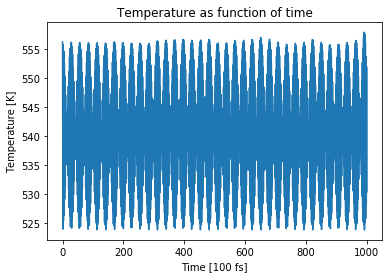

In [11]:
plt.title('Temperature as function of time')

plt.plot(list_temperature /kelvin)

plt.xlabel('Time [100 fs]')
plt.ylabel('Temperature [K]')

## Calulcate kinetic energy

We can also calculate the kinetic energy of the system instead of extracting it.

Therefore, we need the velocities and masses of all atoms.

In [12]:
def get_masses(system):
    "get atom masses as list"
    masses = [system.getParticleMass(i)/dalton for i in range(system.getNumParticles())]
    return Quantity(masses, unit=dalton)

def calculate_kinetic_energy(velocities, masses):
    "calcualte the kinetic energy"
    ke = Quantity(0.0, unit=kilocalorie_per_mole)
    for i, (vx, vy, vz) in enumerate(velocities):
        v_magnitude = sqrt(vx**2 + vy**2 + vz**2)
        ke += 0.5 * v_magnitude**2 * masses[i]
    return ke

In [13]:
masses = get_masses(simulation.system)

list_kinetic_energy = Quantity([ calculate_kinetic_energy(vel, masses) 
                                for vel in storage_harmonic_bond['velocities'] ])


Let's compare it with the kinetic energy extracted from the system.

Text(0, 0.5, 'Kinetic energy  [Kcal/mole]')

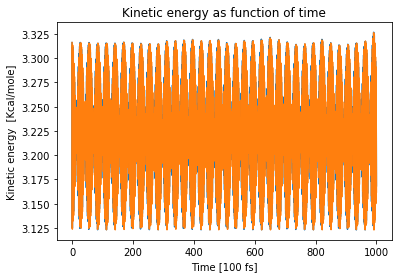

In [14]:
plt.title("Kinetic energy as function of time")
plt.plot(list_kinetic_energy /kilocalorie_per_mole)
plt.plot(storage_harmonic_bond['kinetic_energy'] /kilocalorie_per_mole)

plt.xlabel('Time [100 fs]')
plt.ylabel('Kinetic energy  [Kcal/mole]')

They seem to fit good but there is a slight of set, let's have a look into this and plot the difference between the extracted and calculated energy.

Text(0, 0.5, 'Kinetic energy  [Kcal/mole]')

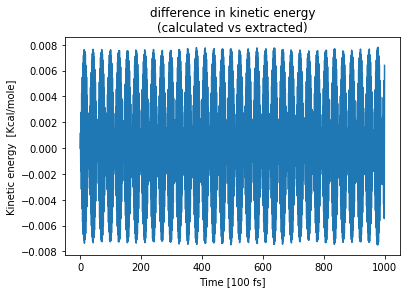

In [15]:
difference_energy = np.array(list_kinetic_energy /kilocalorie_per_mole)
difference_energy-= np.array(storage_harmonic_bond['kinetic_energy'] /kilocalorie_per_mole)

plt.title('difference in kinetic energy\n(calculated vs extracted)')

plt.plot(difference_energy)

plt.xlabel('Time [100 fs]')
plt.ylabel('Kinetic energy  [Kcal/mole]')

The reason behind this could be that we only have the velocities of a full time step, while OpenMM gets the kinetic energy from the half-time step.

We can can test this by redo the experiment and use a velocity-verlet integrator this time instead of a leap-frog.
This means we should now get the full-time step kinetic energy from OpenMM.

### Leap-frog vs Verlocity-Verlet

Let's redo the whole procedure but this time with a velocity-verlet integrator.

In [16]:
diatom = openmmtools.testsystems.Diatom(K=K, r0=r0, m1=m1, m2=m2)
# NOW use a VelocityVerletIntegrator
integrator = openmmtools.integrators.VelocityVerletIntegrator(1 * femtosecond)

sim_vv = app.Simulation(topology=diatom.topology,
                            system=diatom.system,
                            integrator=integrator)
sim_vv.context.setPositions(diatom.positions)
sim_vv.context.setVelocitiesToTemperature(300*kelvin)

In [17]:
storage_harmonic_bond_vv = {
    'positions'        : Quantity([], unit=angstrom),
    'velocities'       : Quantity([], unit=angstrom/femtosecond),
    'forces'           : Quantity([], unit=kilocalorie/(angstrom*mole)),
    'potential_energy' : Quantity([], unit=kilocalorie_per_mole),
    'kinetic_energy'   : Quantity([], unit=kilocalorie_per_mole),
}

# define a state
state = sim_vv.context.getState(getPositions=True, 
                                    getForces=True,
                                    getVelocities=True,
                                    getEnergy=True)

# add the first frame
storage_harmonic_bond_vv['positions'].append(deepcopy( state.getPositions() ) )
storage_harmonic_bond_vv['velocities'].append(deepcopy( state.getVelocities() ) )
storage_harmonic_bond_vv['forces'].append(deepcopy( state.getForces() ))
storage_harmonic_bond_vv['potential_energy'].append(deepcopy( state.getPotentialEnergy() ))
storage_harmonic_bond_vv['kinetic_energy'].append(deepcopy( state.getKineticEnergy() ))

# repeatedly simulate the system for a short period
# extract the properties from the state
for i in range(1000):
    sim_vv.step(100)
    
    # define a state
    state = sim_vv.context.getState(getPositions=True, 
                                        getForces=True,
                                        getVelocities=True,
                                        getEnergy=True)
    
    # update storage
    storage_harmonic_bond_vv['positions'].append(deepcopy( state.getPositions() ) )
    storage_harmonic_bond_vv['velocities'].append(deepcopy( state.getVelocities() ) )
    storage_harmonic_bond_vv['forces'].append(deepcopy( state.getForces() ))
    storage_harmonic_bond_vv['potential_energy'].append(deepcopy( state.getPotentialEnergy() ))
    storage_harmonic_bond_vv['kinetic_energy'].append(deepcopy( state.getKineticEnergy() ))

Let's calculate the kinetic energy again.

In [18]:
masses = get_masses(sim_vv.system)

list_kinetic_energy = Quantity([ calculate_kinetic_energy(vel, masses) 
                                for vel in storage_harmonic_bond_vv['velocities'] ])


And compute the difference in kinetic energy between the calculated and the one extracted directly from OpenMM when using the velocity-verlet integrator.

Text(0, 0.5, 'Kinetic energy  [Kcal/mole]')

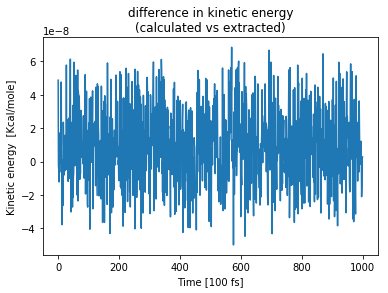

In [19]:
difference_energy = np.array(list_kinetic_energy /kilocalorie_per_mole)
difference_energy-= np.array(storage_harmonic_bond_vv['kinetic_energy'] /kilocalorie_per_mole)

plt.title('difference in kinetic energy\n(calculated vs extracted)')

plt.plot(difference_energy)

plt.xlabel('Time [100 fs]')
plt.ylabel('Kinetic energy  [Kcal/mole]')

Now the difference is in the range of single precision floating point errors.